#9.1 GAN 기초

##9.1.1 생성자와 판별자

생성자 : 가짜 이미지를 생성함

판별자 : 진짜와 가짜를 구분함

-> 생성자는 판별자를 속이려고 성장, 판별자는 잘 구분하려고 성장..

-> 둘다 성장한다..

#9.2 GAN으로 새로운 패션 아이템 생성하기

##9.2.1 학습 준비

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
EPOCHS = 50
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),   #텐서로 바꾸고
       transforms.Normalize((0.5,), (0.5,))     #각 채널에 맞게 정규화..
    ])
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



##9.2.2 생성자와 판별자 구현

그럴듯한 '가짜'는 '진짜'의 분포를 닮는다.

생성자

: 64차원의 무작위 텐서를 입력받아 784차원(28*28) 로 바꾼다.

In [4]:
# 생성자 (Generator)

G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())      # -1 ~ 1의 값

판별자

: 784차원의 텐서를 입력받아 진짜인지 가짜인지 분류하는 분류모델

: LeakyReLU() : 음의 기울기도 전달함

In [5]:
# 판별자 (Discriminator)

D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())       # 0 ~ 1의 값..

##9.2.3 GAN 학습 구현

레이블이 두개.. -> 이진 교차 엔트로피

최적화 함수 Adam

In [6]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

시간상 EPOCHS를 500 -> 50으로 줄여서 확인..

- d_loss : 판별자의 오차
- g_loss : 생성자의 오차
- D(x) : 진짜를 진짜로 인식한 정확도
- D(G(z)) : 가짜를 진짜로 인식한 정확도
    - fake_score는 0이 나와야 좋은건데 판별자에 통과시키고 평균내면 평균적으로 1이 얼마나 나왔는가에 대한 수치이다..

EPOCHS 500 결과 : d_loss:1.3055, g_loss: 1.0484, D(x):0.61, D(G(z)):0.45

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        #이미지는 진짜 이미지를 불러오는거임..
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        outputs = D(images)     #진짜 이미지에 대한 판별결과
        d_loss_real = criterion(outputs, real_labels)       #진짜를 잘못 인식하는 오차
        real_score = outputs    #진짜를 진짜로 판별한 점수..
        

        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)  #랜덤 64차원 텐서
        fake_images = G(z)      #이미지 형태로 생성.. 가짜이미지..
        
        #가짜 이미지에 대한 판별결과(1(진짜)이면 틀린거임..)
        #이걸 평균내면 평균적으로 얼마나 가짜를 진짜로 착각했냐는 거임..
        outputs = D(fake_images)    
        d_loss_fake = criterion(outputs, fake_labels)       #가짜를 잘못 인식하는 오차
        fake_score = outputs    #가짜를 진짜로 판별한 점수..
        
        #진짜 오차와 가짜 오차의 합
        d_loss = d_loss_real + d_loss_fake


        # 판별자 학습.. 가짜와 진짜 합쳐서 얼마나 오차가 있었나..
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()   #전체 오차에 대한 역전파..
        d_optimizer.step()
        

        #생성자 학습..
        fake_images = G(z)
        outputs = D(fake_images)    #가짜를 판별했을때 결과..
        g_loss = criterion(outputs, real_labels)    #진짜와의 오차
        
        # 생성자 학습..
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()       #오차에 대한 역전파..
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/50], d_loss: 0.1581, g_loss: 4.0343, D(x): 0.95, D(G(z)): 0.09
Epoch [1/50], d_loss: 0.0191, g_loss: 5.5430, D(x): 0.99, D(G(z)): 0.01
Epoch [2/50], d_loss: 0.0552, g_loss: 7.6510, D(x): 0.99, D(G(z)): 0.00
Epoch [3/50], d_loss: 0.0559, g_loss: 6.4967, D(x): 0.97, D(G(z)): 0.01
Epoch [4/50], d_loss: 0.0621, g_loss: 7.3458, D(x): 0.99, D(G(z)): 0.02
Epoch [5/50], d_loss: 0.0875, g_loss: 6.5091, D(x): 0.97, D(G(z)): 0.02
Epoch [6/50], d_loss: 0.0756, g_loss: 11.3889, D(x): 0.98, D(G(z)): 0.00
Epoch [7/50], d_loss: 0.0895, g_loss: 6.2306, D(x): 0.96, D(G(z)): 0.02
Epoch [8/50], d_loss: 0.0653, g_loss: 5.0115, D(x): 0.99, D(G(z)): 0.05
Epoch [9/50], d_loss: 0.1456, g_loss: 6.1746, D(x): 0.96, D(G(z)): 0.04
Epoch [10/50], d_loss: 0.2548, g_loss: 4.0137, D(x): 0.94, D(G(z)): 0.08
Epoch [11/50], d_loss: 0.2054, g_loss: 5.7679, D(x): 0.92, D(G(z)): 0.02
Epoch [12/50], d_loss: 0.2407, g_loss: 5.3854, D(x): 0.90, D(G(z)): 0.02
Epoch [13/50], d_loss: 0.2170, g_loss: 4.1530, D(x): 0.93, D

- 생성자보다 판별자의 학습이 빠르다
- 학습이 진행될수록 판별자의 정확도가 50%근처로 내려간다
- 즉, 진짜와 가짜를 구별하지 못한다.. -> 생성자는 진짜와 비슷한 이미지를 만들 수 있게 된다

##9.2.4 결과물 시각화

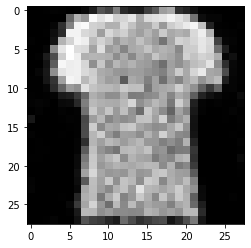

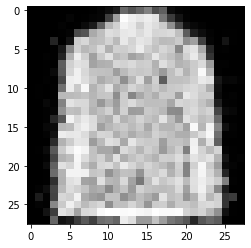

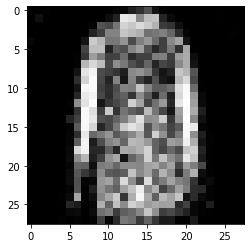

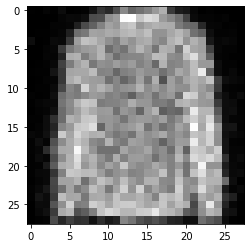

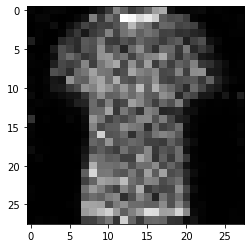

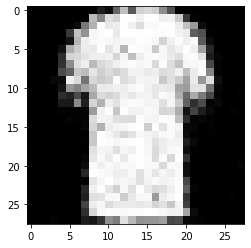

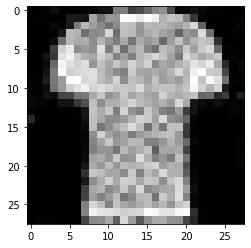

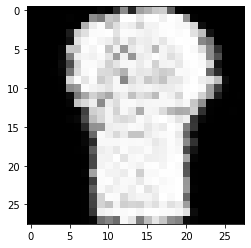

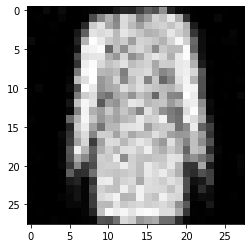

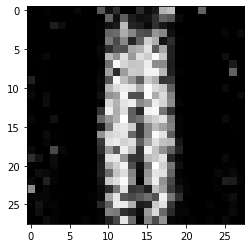

In [8]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    #생성자로 만든 가짜이미지를 이미지형태로 변환
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()

-> epoch가 작아서 대략적으로만 확인되는 모습..

#9.3 cGAN으로 생성 제어하기

- conditional GAN

##9.3.1 cGAN으로 원하는 이미지 생성하기

- 앞 절에서는 무작위 종류의 이미지를 생성한다..
- 이제는 원하는 이미지를 생성한다..

-> **어떤 아이템을 생성하고자 하는지에 대한 정보를 입력받아야한다!**

- 생성자와 판별자의 입력에 레이블 정보를 이어붙힌다!

준비 사항 동일

In [9]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# 하이퍼파라미터
EPOCHS = 50
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [16]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

##9.3.2 조건부 생성자와 판별자

생성자

: 가짜 이미지를 생성할 때 무작위 레이블을 같이 넘겨줌..

In [17]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #레이블 크기 (배치, 1) -> (배치, 10)으로 조정
        self.embed = nn.Embedding(10, 10)   
        
        #실제 입력을 행렬곱을 이용하여 가짜 이미지 크기(784)로 만드는 함수
        self.model = nn.Sequential(
            nn.Linear(110, 256),        #원래 100크기의 무작위 텐서 + 무작위 레이블 10
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    #입력(z)과 무작위 레이블(labels)을 가지고 가짜 이미지 생성
    def forward(self, z, labels):
        c = self.embed(labels)  #무작위 레이블..
        x = torch.cat([z, c], 1)        #입력과 무작위 레이블 합침
        return self.model(x)    #가짜 이미지 생성

판별자

: 판별자 역시 진짜 이미지에 대한 레이블이 필요함

In [18]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #레이블 크기 (배치, 1) -> (배치, 10)으로 조정
        self.embed = nn.Embedding(10, 10)
        
        #이미지를 DNN에 통과.. 드롭아웃 적용
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    #진짜 이미지와 그에 대한 레이블을 입력받아 진짜/가짜를 판별..
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

##9.3.3 cGAN 학습 구현

In [19]:
#생성, 판별자 인스턴스 생성
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

#오차함수 및 최적화 객체 생성
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr =0.0002)
g_optimizer = optim.Adam(G.parameters(), lr =0.0002)

In [20]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)      #이미지를 열벡터로 크기 조정.. (원래 28 * 28)
        
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)      #진짜 레이블 생성
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)     #가짜 레이블 생성

        #진짜 to 진짜
        labels = labels.to(DEVICE)  #진짜 이미지에 대한 레이블..
        outputs = D(images, labels)     #진짜를 판별하자

        #진짜 이미지를 진짜로 인식하는 오차 계산..
        d_loss_real = criterion(outputs, real_labels)       
        real_score = outputs
    
        #가짜 to 가짜
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)     #랜덤 벡터 생성..(크기 100)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)        #랜덤 레이블 생성..
        fake_images = G(z, g_label)     #랜덤 벡터로 랜덤 레이블에 대한 가짜 이미지를 만듦
        
        #가짜 이미지와 그에 대한 레이블을 판별자에 통과..
        # 0이 맞춘건데 이걸 평균내면 1을 평균내는 거임..
        outputs = D(fake_images, g_label)   
        d_loss_fake = criterion(outputs, fake_labels)       #가짜 to 가짜 오차 계산
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake      #전체 오차..
        
        # 판별자 학습
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        fake_images = G(z, g_label)     #생성자가 만든 이미지를
        outputs = D(fake_images, g_label)       #판별자에 통과..
        g_loss = criterion(outputs, real_labels)        #오차 계산..

        # 생성자 학습..
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    #판별자 오차, 생성자 오차, 진짜를 제대로 했는지, 가짜를 진짜로 한 점수..
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  EPOCHS,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

이폭 [0/50] d_loss:0.2091 g_loss: 6.7175 D(x):0.90 D(G(z)):0.07
이폭 [1/50] d_loss:0.3298 g_loss: 3.0010 D(x):0.88 D(G(z)):0.13
이폭 [2/50] d_loss:0.5105 g_loss: 2.8579 D(x):0.83 D(G(z)):0.15
이폭 [3/50] d_loss:0.5689 g_loss: 3.3994 D(x):0.88 D(G(z)):0.20
이폭 [4/50] d_loss:0.7688 g_loss: 2.3008 D(x):0.84 D(G(z)):0.31
이폭 [5/50] d_loss:0.3993 g_loss: 2.5768 D(x):0.85 D(G(z)):0.15
이폭 [6/50] d_loss:0.5417 g_loss: 2.0586 D(x):0.85 D(G(z)):0.24
이폭 [7/50] d_loss:0.7277 g_loss: 1.8224 D(x):0.83 D(G(z)):0.26
이폭 [8/50] d_loss:0.5295 g_loss: 2.5847 D(x):0.82 D(G(z)):0.16
이폭 [9/50] d_loss:0.8054 g_loss: 1.8511 D(x):0.76 D(G(z)):0.29
이폭 [10/50] d_loss:0.8729 g_loss: 1.6589 D(x):0.77 D(G(z)):0.33
이폭 [11/50] d_loss:0.6911 g_loss: 1.9063 D(x):0.74 D(G(z)):0.22
이폭 [12/50] d_loss:0.6767 g_loss: 2.1123 D(x):0.79 D(G(z)):0.23
이폭 [13/50] d_loss:0.8798 g_loss: 1.5787 D(x):0.77 D(G(z)):0.34
이폭 [14/50] d_loss:0.8411 g_loss: 1.6072 D(x):0.72 D(G(z)):0.28
이폭 [15/50] d_loss:0.7492 g_loss: 1.8125 D(x):0.74 D(G(z)):0.23
이폭

##9.3.4 결과물 시각화

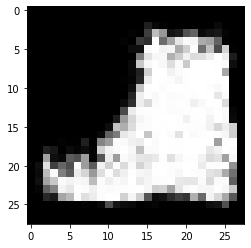

In [21]:
item_number = 9 # 앵클부츠..

# 배치 크기 1, 랜덤 벡터..
z = torch.randn(1, 100).to(DEVICE) 

# 원하는 레이블을 담은 텐서 생성..
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)        

# 가짜 이미지 생성.. 결과는 (1, 784) 크기..
sample_images = G(z, g_label)

# 시각화 할 수 있게 shape 조정
sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()

#9.4 마치며

- 레이블에 대한 정보대신 메세지나 다른 그림도 자유롭게 줄 수 있다..
- 서로 적대적이면서 서로 발전하는 알고리즘이다..